In [1]:
import pandas as pd
# from google.colab import drive
# import warnings
# warnings.filterwarnings("ignore")
import sklearn
from tqdm import tqdm
import networkx as nx
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn import preprocessing as p
import math
import numpy as np
import collections
from scipy.spatial import Voronoi, voronoi_plot_2d
# from shapely.geometry import Polygon
import scipy as sp
import scipy.spatial
import sys
import matplotlib.image as mpimg
import sklearn.metrics as metrics
from sklearn.calibration import calibration_curve
from spektral.data import Dataset, Graph, DisjointLoader
from spektral.layers import CrystalConv, GlobalAvgPool
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [16]:
folder = r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\Sample_data\sample-data\data\Sample_Game_3'

In [30]:
# Read the text file into a list of strings
game_3 = folder + '\\Sample_Game_3_tracking.txt'

# Read the text file into a list of strings
with open(game_3, 'r') as file:
    lines = file.readlines()

# Prepare a list to store the data
data = []

# Process each line to extract the coordinates
for line in lines:
    # Split the line by ':' to separate the player coordinates from the unknown coordinates
    parts = line.strip().split(':')
    
    # Extract the time
    time = parts[0]
    
    # Split the remaining part by ';' and then by ',' to get x and y values
    player_coords = parts[1].split(';')
    player_coords = [coord.split(',') for coord in player_coords]
    
    # Flatten the list of player coordinates and convert to float
    player_coords = [float(item) for sublist in player_coords for item in sublist]
    
    # Split the unknown coordinates by ',' and convert to float
    unknown_coords = [float(coord) for coord in parts[2].split(',')]
    
    # Combine time, player coordinates, and unknown coordinates
    row = [time] + player_coords + unknown_coords
    
    # Append the row to the data list
    data.append(row)

# Define column names
coord_columns = [f'{i+1}_{j}' for i in range(22) for j in ('x','y')]

columns = ['time'] + coord_columns + ['unknown_x', 'unknown_y']

# Create the DataFrame
df = pd.DataFrame(data, columns=columns)

# data = df
# Display the DataFrame
df.head()

,time,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,5_x,5_y,6_x,6_y,7_x,7_y,8_x,8_y,9_x,9_y,10_x,10_y,11_x,11_y,12_x,12_y,13_x,13_y,14_x,14_y,15_x,15_y,16_x,16_y,17_x,17_y,18_x,18_y,19_x,19_y,20_x,20_y,21_x,21_y,22_x,22_y,unknown_x,unknown_y
0,1,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,0.62405,0.80669,0.50533,0.15735,0.60798,0.45155,0.50212,0.45314,0.62012,0.60667,0.51839,0.77140,0.50555,0.50863,0.0811,0.49705,0.34297,0.79907,0.28837,0.69449,0.30493,0.42784,0.32492,0.22684,0.44476,0.62375,0.41381,0.52790,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,NaN,NaN
1,2,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,0.62371,0.80594,0.50461,0.15436,0.60783,0.44918,0.50158,0.45544,0.61987,0.60474,0.51801,0.77130,0.50545,0.50532,0.0811,0.49705,0.34200,0.79786,0.28804,0.69280,0.30419,0.42802,0.32400,0.22230,0.44417,0.62192,0.41375,0.52780,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,NaN,NaN
2,3,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,0.62354,0.80601,0.50430,0.15409,0.60779,0.44866,0.50126,0.45662,0.61980,0.60422,0.51787,0.77080,0.50552,0.50524,0.0811,0.49705,0.34137,0.79690,0.28824,0.69294,0.30390,0.42819,0.32353,0.22072,0.44423,0.62147,0.41371,0.52906,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,NaN,NaN
3,4,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,0.62318,0.80604,0.50394,0.15279,0.60762,0.44898,0.50119,0.45815,0.61976,0.60397,0.51773,0.77031,0.50563,0.50524,0.0811,0.49705,0.34102,0.79657,0.28837,0.69270,0.30373,0.42840,0.32307,0.21960,0.44422,0.62132,0.41370,0.53056,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,NaN,NaN
4,5,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,0.62286,0.80626,0.50371,0.15286,0.60748,0.44888,0.50114,0.45986,0.61967,0.60417,0.51759,0.77008,0.50576,0.50531,0.0811,0.49705,0.34085,0.79649,0.28843,0.69270,0.30325,0.42789,0.32300,0.21914,0.44437,0.62189,0.41369,0.53151,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,NaN,NaN


In [31]:
data = df.copy()

# Display all columns
pd.set_option('display.max_columns', None)

# Display all rows
pd.set_option('display.max_rows', None)

print(data.isna().sum())

time             0
1_x              0
1_y              0
2_x              0
2_y              0
3_x              0
3_y              0
4_x              0
4_y              0
5_x              0
5_y              0
6_x              0
6_y              0
7_x              0
7_y              0
8_x              0
8_y              0
9_x              0
9_y              0
10_x             0
10_y             0
11_x             0
11_y             0
12_x             0
12_y             0
13_x             0
13_y             0
14_x             0
14_y             0
15_x             0
15_y             0
16_x             0
16_y             0
17_x             0
17_y             0
18_x             0
18_y             0
19_x             0
19_y             0
20_x             0
20_y             0
21_x             0
21_y             0
22_x             0
22_y             0
unknown_x    46325
unknown_y    46325
dtype: int64


In [32]:
data.head()

,time,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,5_x,5_y,6_x,6_y,7_x,7_y,8_x,8_y,9_x,9_y,10_x,10_y,11_x,11_y,12_x,12_y,13_x,13_y,14_x,14_y,15_x,15_y,16_x,16_y,17_x,17_y,18_x,18_y,19_x,19_y,20_x,20_y,21_x,21_y,22_x,22_y,unknown_x,unknown_y
0,1,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,0.62405,0.80669,0.50533,0.15735,0.60798,0.45155,0.50212,0.45314,0.62012,0.60667,0.51839,0.77140,0.50555,0.50863,0.0811,0.49705,0.34297,0.79907,0.28837,0.69449,0.30493,0.42784,0.32492,0.22684,0.44476,0.62375,0.41381,0.52790,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,NaN,NaN
1,2,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,0.62371,0.80594,0.50461,0.15436,0.60783,0.44918,0.50158,0.45544,0.61987,0.60474,0.51801,0.77130,0.50545,0.50532,0.0811,0.49705,0.34200,0.79786,0.28804,0.69280,0.30419,0.42802,0.32400,0.22230,0.44417,0.62192,0.41375,0.52780,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,NaN,NaN
2,3,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,0.62354,0.80601,0.50430,0.15409,0.60779,0.44866,0.50126,0.45662,0.61980,0.60422,0.51787,0.77080,0.50552,0.50524,0.0811,0.49705,0.34137,0.79690,0.28824,0.69294,0.30390,0.42819,0.32353,0.22072,0.44423,0.62147,0.41371,0.52906,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,NaN,NaN
3,4,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,0.62318,0.80604,0.50394,0.15279,0.60762,0.44898,0.50119,0.45815,0.61976,0.60397,0.51773,0.77031,0.50563,0.50524,0.0811,0.49705,0.34102,0.79657,0.28837,0.69270,0.30373,0.42840,0.32307,0.21960,0.44422,0.62132,0.41370,0.53056,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,NaN,NaN
4,5,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,0.62286,0.80626,0.50371,0.15286,0.60748,0.44888,0.50114,0.45986,0.61967,0.60417,0.51759,0.77008,0.50576,0.50531,0.0811,0.49705,0.34085,0.79649,0.28843,0.69270,0.30325,0.42789,0.32300,0.21914,0.44437,0.62189,0.41369,0.53151,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,NaN,NaN


In [33]:
def check_zero_coordinates(data):
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data is not a DataFrame")
    
    print("Checking for zero coordinates...")
    zero_coords = (data == 0).sum()
    zero_coords = zero_coords[zero_coords > 0]
    if not zero_coords.empty:
        print("Players with zero coordinates found:")
        print(zero_coords)
    else:
        print("No zero coordinates found.")
        
check_zero_coordinates(data)

Checking for zero coordinates...
Players with zero coordinates found:
3_x     1
8_x     1
12_x    1
16_y    3
17_x    2
19_y    1
dtype: int64


In [34]:
df[df['unknown_x'].notna()].head()

,time,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,5_x,5_y,6_x,6_y,7_x,7_y,8_x,8_y,9_x,9_y,10_x,10_y,11_x,11_y,12_x,12_y,13_x,13_y,14_x,14_y,15_x,15_y,16_x,16_y,17_x,17_y,18_x,18_y,19_x,19_y,20_x,20_y,21_x,21_y,22_x,22_y,unknown_x,unknown_y
360,361,0.84219,0.51681,0.63861,0.19465,0.73474,0.38597,0.71661,0.65952,0.55391,0.90220,0.50242,0.12687,0.61177,0.44792,0.50127,0.48734,0.61540,0.61950,0.50777,0.80033,0.50125,0.48725,0.0811,0.49705,0.33609,0.79151,0.31093,0.61000,0.29696,0.41736,0.31920,0.21937,0.45231,0.61973,0.41598,0.54809,0.41560,0.47430,0.41384,0.36745,0.49025,0.65068,0.48714,0.36308,0.50125,0.48725
361,362,0.84232,0.51649,0.63826,0.19424,0.73488,0.38666,0.71668,0.65969,0.55393,0.90261,0.50240,0.12631,0.61180,0.44815,0.50111,0.48759,0.61543,0.61955,0.50762,0.80055,0.50108,0.48750,0.0811,0.49705,0.33619,0.79153,0.31103,0.61013,0.29696,0.41726,0.31925,0.21898,0.45253,0.61955,0.41645,0.54800,0.41584,0.47443,0.41406,0.36780,0.49038,0.65010,0.48732,0.36310,0.50111,0.48724
362,363,0.84246,0.51620,0.63792,0.19398,0.73500,0.38738,0.71673,0.65993,0.55395,0.90302,0.50238,0.12578,0.61182,0.44831,0.50095,0.48786,0.61547,0.61963,0.50746,0.80087,0.50089,0.48777,0.0811,0.49705,0.33631,0.79156,0.31116,0.61028,0.29695,0.41711,0.31932,0.21850,0.45279,0.61938,0.41696,0.54799,0.41610,0.47458,0.41430,0.36810,0.49055,0.64946,0.48753,0.36305,0.50095,0.48723
363,364,0.84262,0.51583,0.63761,0.19364,0.73515,0.38793,0.71680,0.66012,0.55397,0.90340,0.50238,0.12528,0.61184,0.44858,0.50080,0.48815,0.61553,0.61964,0.50732,0.80120,0.50070,0.48806,0.0811,0.49705,0.33641,0.79152,0.31130,0.61038,0.29698,0.41698,0.31943,0.21816,0.45307,0.61917,0.41749,0.54794,0.41636,0.47458,0.41454,0.36831,0.49077,0.64890,0.48778,0.36303,0.50079,0.48721
364,365,0.84282,0.51546,0.63733,0.19331,0.73530,0.38849,0.71688,0.66031,0.55399,0.90378,0.50238,0.12480,0.61188,0.44869,0.50065,0.48838,0.61560,0.61973,0.50715,0.80148,0.50050,0.48828,0.0811,0.49705,0.33654,0.79149,0.31146,0.61057,0.29699,0.41679,0.31955,0.21773,0.45339,0.61897,0.41806,0.54791,0.41665,0.47469,0.41481,0.36846,0.49101,0.64828,0.48807,0.36314,0.50063,0.48720


In [35]:
data['time'] = data['time'].astype('int64')

# This means keeping rows where the time is a multiple of 25
filtered_data = data[data['time'] % 25 == 0]

# Update data
data = filtered_data

# Denormalizing the coordinates
for i in data.columns:
    if 'x' in i:
        data.loc[:, i] = data[i] * 105
    elif 'y' in i:
        data.loc[:, i] = data[i] * 68

In [36]:
data.head()

,time,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,5_x,5_y,6_x,6_y,7_x,7_y,8_x,8_y,9_x,9_y,10_x,10_y,11_x,11_y,12_x,12_y,13_x,13_y,14_x,14_y,15_x,15_y,16_x,16_y,17_x,17_y,18_x,18_y,19_x,19_y,20_x,20_y,21_x,21_y,22_x,22_y,unknown_x,unknown_y
24,25,88.9581,35.9414,68.26470,16.06092,70.35420,31.13040,71.59320,40.18188,64.92675,54.87124,52.78035,10.47132,63.86205,30.75164,52.58400,31.65672,64.93095,41.28212,54.29025,52.08596,53.04180,33.73888,8.5155,33.7994,35.59920,54.04708,30.59805,46.47188,31.49055,29.72008,33.75015,14.87500,46.94550,42.36400,43.24635,36.86348,43.72725,32.30748,43.26315,23.66740,50.46720,49.34692,51.15600,24.53712,NaN,NaN
49,50,88.9581,35.9414,68.45790,15.88344,71.57220,30.78904,72.13080,40.92172,64.57185,55.02356,52.73835,10.26256,64.06785,30.79516,52.63860,31.66352,64.92780,41.50788,54.27975,52.09276,53.07750,33.34448,8.5155,33.7994,35.49105,53.83832,31.10205,45.45596,31.11360,30.34024,33.64830,14.58872,47.15445,42.52584,43.08150,37.47820,43.76505,32.34284,43.56345,22.79700,50.94705,48.28884,51.06675,24.37936,NaN,NaN
74,75,88.9581,35.9414,68.76975,15.68148,73.29945,30.71492,72.87840,41.88188,64.38285,55.48868,52.79505,9.50368,64.33245,30.56124,52.81080,32.17556,65.10315,41.62552,54.22935,52.32736,53.13945,33.31388,8.5155,33.7994,35.56455,53.78664,31.64175,44.43596,30.93090,30.38648,33.47085,14.31060,47.15970,42.56664,42.97965,37.59448,43.75455,32.41560,44.11365,22.00820,50.86095,47.41504,51.04890,24.31272,NaN,NaN
99,100,88.9581,35.9414,68.78550,15.51760,74.52690,31.00800,73.31205,42.55100,63.96495,55.86540,52.86855,8.96376,64.30095,30.48780,52.99350,32.66244,65.12415,41.79212,54.11490,52.62520,53.00190,32.71004,8.5155,33.7994,35.63910,53.93964,32.13420,43.61044,31.02120,29.69016,33.31965,14.47448,47.13555,42.75092,42.95970,37.75564,43.70205,32.36664,44.86755,21.47100,50.80320,46.59428,51.06780,24.49700,NaN,NaN
124,125,88.9581,35.9414,68.93460,15.29320,74.73165,31.11000,73.58715,42.87672,63.44625,56.28972,52.90110,8.69312,63.93765,30.69044,53.13315,32.49720,64.96350,42.01380,53.86920,53.12296,53.13315,32.49720,8.5155,33.7994,35.55720,53.90156,32.46180,43.06032,31.30680,28.74768,33.40470,14.61728,47.04210,42.79036,43.07100,37.71552,43.63275,32.60124,45.57525,21.30372,50.96385,45.81500,51.08355,24.57656,NaN,NaN


In [38]:
# Divide the DataFrame into two halves based on the time column
first_half = data[data['time'] < 70090].copy()
second_half = data[data['time'] >= 70090].copy()

In [41]:
# Create a dictionary for first_half
points_22 = {}
for idx, row in first_half.iterrows():
    frame = row['time']
    points = []
    for i in range(1, 23):
        x = row[f'{i}_x']
        y = row[f'{i}_y']
        points.append((x, y))
    points_22[frame] = points

# Create a dictionary for second_half
points_22_final = {}
for idx, row in second_half.iterrows():
    frame = row['time']
    points = []
    for i in range(1, 23):
        x = row[f'{i}_x']
        y = row[f'{i}_y']
        points.append((x, y))
    points_22_final[frame] = points

In [42]:
# instant player data captures the player_id, nearest points count from knn, area for each frame
# "Player", i+1, "Nearest Points Count:", count, "Area : ", (count/(68*105)*1000)
# player_count_area_1 is for all frames

import numpy as np
from sklearn.neighbors import NearestNeighbors

# Generate 1000 random points on the soccer field
random_points = np.random.uniform(low=[0, 0], high=[105, 68], size=(10000, 2))

player_count_area_1 = []

# Define the coordinates of the 22 players on the soccer field
for i,j in points_22.items():
  player_coordinates = points_22[i]


# Create a NearestNeighbors object and fit it with player coordinates
  knn = NearestNeighbors(n_neighbors=1)
  knn.fit(player_coordinates)

# Find the nearest neighbor for each random point
  distances, indices = knn.kneighbors(random_points)

# Count the number of nearest points for each player
  nearest_points_count = np.zeros(22)
  for index in indices.flatten():
      player_index = index  # Assuming the player indices start from 0
      nearest_points_count[player_index] += 1

  instant_player_data = []


# Print the nearest points count for each player
  for i, count in enumerate(nearest_points_count):
    # print("Player", i+1, "Nearest Points Count:", count, "Area : ", (count/(68*105)*1000))
    instant_player_data.append((i+1,int(count), count/(68*105)*1000))
  player_count_area_1.append(instant_player_data)

In [43]:
random_points = np.random.uniform(low=[0, 0], high=[105, 68], size=(10000, 2))

player_count_area_2 = []

# Define the coordinates of the 22 players on the soccer field
for i,j in points_22_final.items():
  player_coordinates = points_22_final[i]


# Create a NearestNeighbors object and fit it with player coordinates
  knn = NearestNeighbors(n_neighbors=1)
  knn.fit(player_coordinates)

# Find the nearest neighbor for each random point
  distances, indices = knn.kneighbors(random_points)

# Count the number of nearest points for each player
  nearest_points_count = np.zeros(22)
  for index in indices.flatten():
      player_index = index  # Assuming the player indices start from 0
      nearest_points_count[player_index] += 1

  instant_player_data = []


# Print the nearest points count for each player
  for i, count in enumerate(nearest_points_count):
    # print("Player", i+1, "Nearest Points Count:", count, "Area : ", (count/(68*105)*1000))
    instant_player_data.append((i+1,int(count), count/(68*105)*1000))
  player_count_area_2.append(instant_player_data)

In [44]:
# influence is calculated from "Area : ", (count/(68*105)*1000) where is count is number of nearest points from KNN for all frames
# influence format is [[influence of player 1, 2,...],[influence of player 1, 2,...],...]
# influence_1half shape is 1987*22*1

influence_1half = []

for i in range(len(player_count_area_1)):
  influence_at_i = [t[2] for t in player_count_area_1[i]]
  influence_1half.append(influence_at_i)

In [45]:
influence_2half = []

for i in range(len(player_count_area_2)):
  influence_at_i = [t[2] for t in player_count_area_2[i]]
  influence_2half.append(influence_at_i)

In [46]:
# Adjust influences for overlapping coordinates
def adjust_influence(points, influences):
    for frame in range(len(points)):
        coords_to_indices = {}
        for i, (x, y) in enumerate(points[frame]):
            if (x, y) not in coords_to_indices:
                coords_to_indices[(x, y)] = []
            coords_to_indices[(x, y)].append(i)

        for indices in coords_to_indices.values():
            if len(indices) > 1:
                total_influence = sum(influences[frame][i] for i in indices)
                average_influence = total_influence / len(indices)
                for i in indices:
                    influences[frame][i] = average_influence

# Adjust influences for the first half
points_22_list = [[(x, y) for (x, y) in frame_coords] for frame_coords in points_22.values()]
adjust_influence(points_22_list, influence_1half)

# Adjust influences for the second half
points_22_final_list = [[(x, y) for (x, y) in frame_coords] for frame_coords in points_22_final.values()]
adjust_influence(points_22_final_list, influence_2half)

In [21]:
# coords_inf_array.shape

In [22]:
# n_train = int(0.8 * (coords_inf_array.shape[0]-2))
# print(n_train)
# test_influence = coords_inf_array[n_train:]

In [47]:
# for i, inf in enumerate(test_influence[0]):
#     print(f'{i+1:<2}: inf:{inf[0]:<25} x:{inf[1]:<25} y:{inf[2]}')

for i, inf in enumerate(influence_1half[0]):
    print(f'{i+1:<2}: {inf}')

# # split influence if 2 points are overlapping
# # store substitutions in a list
# # total residue graph, x axis has total residue for each player - for 2 models
# # residue over time for each player
# # loss graphs for 2 models

1 : 242.7170868347339
2 : 136.69467787114846
3 : 31.932773109243694
4 : 40.616246498599445
5 : 103.22128851540616
6 : 68.0672268907563
7 : 27.45098039215686
8 : 9.943977591036415
9 : 21.988795518207283
10: 43.69747899159663
11: 15.126050420168067
12: 181.65266106442576
13: 90.61624649859944
14: 86.69467787114846
15: 54.621848739495796
16: 126.61064425770307
17: 21.288515406162464
18: 15.966386554621847
19: 11.904761904761903
20: 22.408963585434172
21: 19.607843137254903
22: 27.731092436974787


In [48]:
# Define the function to plot the soccer field
def plot_soccer_field():
    """Plot a soccer field of dimensions 105x68."""
    fig = plt.figure(figsize=(10.5, 6.8))  # Field size in aspect ratio 105x68
    ax = fig.add_subplot(1, 1, 1)

    # Soccer field dimensions
    plt.xlim(0, 105)
    plt.ylim(0, 68)

    # Add center line and center circle
    plt.plot([52.5, 52.5], [0, 68], color="black")
    center_circle = plt.Circle((52.5, 34), 9.15, color="black", fill=False)
    ax.add_patch(center_circle)

    # Add penalty areas
    penalty_area1 = patches.Rectangle((0, 20.15), 16.5, 27.7, linewidth=1, edgecolor='black', facecolor='none')
    penalty_area2 = patches.Rectangle((88.5, 20.15), 16.5, 27.7, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(penalty_area1)
    ax.add_patch(penalty_area2)

    return ax

# Define the function to label player positions with their influences
def label_points_with_influence(x, y, influences, ax):
    for i in range(len(x)):
        influence_label = f"{i+1} ({influences[i]:.2f})"
        ax.text(x[i], y[i], influence_label, fontsize=8, ha='right', va='bottom')

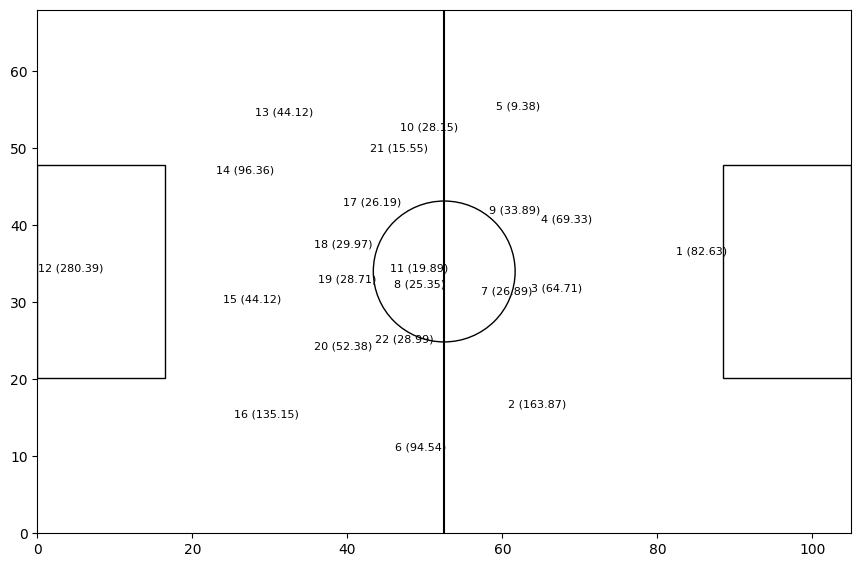

In [51]:
frame_index = 25
player_positions_x = [point[0] for point in points_22[frame_index]]
player_positions_y = [point[1] for point in points_22[frame_index]]
player_influences = influence_1half[frame_index]

# Plot the soccer field
ax = plot_soccer_field()

# Plot player positions and label with influences
label_points_with_influence(player_positions_x, player_positions_y, player_influences, ax)

plt.show()

In [26]:
# time_step = 0
# player_positions_x = [point[0] for point in points_22[frame_index]]
# player_positions_y = [point[1] for point in points_22[frame_index]]
# player_influences = influence_1half[frame_index]

# # Plot the soccer field
# ax = plot_soccer_field()

# # Plot player positions and label with influences
# label_points_with_influence(player_positions_x, player_positions_y, player_influences, ax)

# plt.show()

In [54]:
# Space occupancy is for two teams for first half is: SO_A, SO_B
# SO_A format is {(frame: Space occupancy)}
# SOA_1_zer fills zeroes in frames from 2 to 2714, since size of SO_A is 1987 and max of SO_A is 2714
# SO_A shape is 1987x1
# SO_A[frame_i] + SO_B[frame_i] = 1

indx = first_half.index.tolist()
#print(indx)
SO_A,SO_B={},{}
for coun,indexx in enumerate(indx):
 # print(coun)
  dist_1=[]
  tim = first_half.loc[indexx]['time']
  ball = ball_first[coun]
  points = points_22[indexx]
#   if coun==4:
#     print(points)
  for i in points:
    eucli = math.dist(i, ball)

    if eucli!=0:
      eucli = (1.00000000 / eucli)
      dist_1.append(eucli)
    elif eucli==0:
      eucli = 1  # if distance less than 1 meter then weightage is 1
      dist_1.append(eucli)
  IP=influence_1half[coun]


  Iteam_A = np.dot(np.array(dist_1[:11]),np.array(IP[:11]))
  Iteam_B = np.dot(np.array(dist_1[11:]),np.array(IP[11:]))

  w_a = 1/math.dist(ball, (0,68/2))
  w_b = 1/math.dist(ball, (105,68/2))
  SO_A[tim]= (w_a*Iteam_A)/((w_a*Iteam_A) + (w_b*Iteam_B))
  SO_B[tim] = (w_b*Iteam_B)/((w_a*Iteam_A) + (w_b*Iteam_B))
# print(SO_A,SO_B)
SOA_1_zer,SOB_1_zer={},{}
for i in range(2,2715,1):
  if  i in SO_A.keys():
    SOA_1_zer[i]=SO_A[i]
    SOB_1_zer[i]=SO_B[i]
  else:
    SOA_1_zer[i]=0
    SOB_1_zer[i]=0

NameError: name 'ball_first' is not defined

In [53]:
# Space occupancy is for two teams for second half is: SO_A_2, SO_B_2
# SO_A_2 shape is 1458x1

indx = second_half.index.tolist()
#print(indx)
SO_A_2,SO_B_2={},{}
for coun,indexx in enumerate(indx):
 # print(coun)
  dist_1=[]
  tim = second_half.loc[indexx]['Time [s]']
  ball = ball_second[coun]
  points = points_22_final[indexx]
#   if coun==4:
#     print(points)
  for i in points:
    eucli = math.dist(i, ball)

    if eucli!=0:
      eucli = (1.00000000 / eucli)
      dist_1.append(eucli)
    elif eucli==0:
      eucli = 1  # if distance less than 1 meter then weightage is 1
      dist_1.append(eucli)
  IP=influence_2half[coun]


  Iteam_A = np.dot(np.array(dist_1[:11]),np.array(IP[:11]))
  Iteam_B = np.dot(np.array(dist_1[11:]),np.array(IP[11:]))

  w_a = 1/math.dist(ball, (105,68/2))
  w_b = 1/math.dist(ball, (0,68/2))
  SO_A_2[tim]= (w_a*Iteam_A)/((w_a*Iteam_A) + (w_b*Iteam_B))
  SO_B_2[tim] = (w_b*Iteam_B)/((w_a*Iteam_A) + (w_b*Iteam_B))
# print(SO_A_2,SO_B_2)
SOA_2_zer,SOB_2_zer={},{}
for i in range(2719,5612,1):
  if  i in SO_A_2.keys():
    SOA_2_zer[i]=SO_A_2[i]
    SOB_2_zer[i]=SO_B_2[i]
  else:
    SOA_2_zer[i]=0
    SOB_2_zer[i]=0

KeyError: 'Time [s]'

### SO input for ASTGCN ###

In [29]:
# converting Space occupancy values to dataframe, then to array and then saving as npz

SO_df = pd.DataFrame(list(zip(SO_A.values(), SO_B.values())), index=[int(i) for i in SO_A.keys()])
SO2_df = pd.DataFrame(list(zip(SO_A_2.values(), SO_B_2.values())), index=[int(i) for i in SO_A_2.keys()])
SO_combined = pd.concat([SO_df, SO2_df])
# Convert the DataFrame to a NumPy array
SO_combined_array = SO_combined.to_numpy()

# Save the array to a .npz file with a key
np.savez_compressed(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\Space_occupancy_3.npz',
                   data=SO_combined_array)

### Influence input for ASTGCN ###

In [55]:
# storing influence of first and second half in an npz file

influence_1half_array = np.array(influence_1half)
influence_2half_array = np.array(influence_2half)
combined_influence = np.vstack((influence_1half_array, influence_2half_array))

np.savez_compressed(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\Influence_3.npz',
                   data=combined_influence)

In [56]:
player_coords = np.vstack((np.array(list(points_22.values())), np.array(list(points_22_final.values()))))
# Expanding dimensions of combined_influence to make it (3445, 22, 1)
expanded_influence = np.expand_dims(combined_influence, axis=-1)

# Concatenating along the third dimension to make the new array (3445, 22, 3)
coords_inf_array = np.concatenate((expanded_influence, player_coords), axis=-1)

# Now combined_array.shape should be (3445, 22, 3)
print(coords_inf_array.shape)

np.savez_compressed(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\Coords_Influence_3.npz',
                   data=coords_inf_array)
np.save(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\Coords_Influence_3.npy', coords_inf_array)

(5750, 22, 3)


### Ball coords input ###

In [32]:
ball_coords = np.vstack((np.array(ball_first), np.array(ball_second)))

print(ball_coords.shape)

np.savez_compressed(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\Ball_coords_1.npz',
                   data=ball_coords)

(5801, 2)


In [33]:
# input_1: adjacancy matrices
# adjacancy matrices of 22 players for all frames of first half, here points 22 is the coords of all the players in the first half
# adj_matrices_c shape is 1987x22x22

def adj_mat_c(z_c):
    adj_matrices_c = []
    dist_matrices_c = []
    for index, valu in z_c.items():
        distances = cdist(valu, valu, 'euclidean')
        dist_matrices_c.append(distances)
        adj_matrix_c = np.where(distances<15, 1, 0)
        np.fill_diagonal(adj_matrix_c, 0)
        adj_matrices_c.append(adj_matrix_c)
    return adj_matrices_c, dist_matrices_c
adj_matrices_c, dist_matrices_c =adj_mat_c(points_22)
adj_matrices_c2, dist_matrices_c2 =adj_mat_c(points_22_final)

### adj and dist matrices input for ASTGCN ###

In [34]:
# storing adjacancy and distance matrices in npzy files

adj_matrices_c_array = np.array(adj_matrices_c)
dist_matrices_c_array = np.array(dist_matrices_c)
adj_matrices_c2_array = np.array(adj_matrices_c2)
dist_matrices_c2_array = np.array(dist_matrices_c2)

combined_adj_matrices = np.vstack((adj_matrices_c_array, adj_matrices_c2_array))
combined_dist_matrices = np.vstack((dist_matrices_c_array, dist_matrices_c2_array))

np.save(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\adj_matrices_1.npy', combined_adj_matrices)
np.save(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\dist_matrices_1.npy', combined_dist_matrices)

In [35]:
np.save(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\initial_adj_matrices_1.npy', combined_adj_matrices[0])
np.save(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\initial_dist_matrices_1.npy', combined_dist_matrices[0])

In [36]:
print(combined_influence[:,20])

[10.92436975 11.20448179 13.7254902  ... 40.89635854 41.03641457
 40.89635854]


In [37]:
# coords of players for all frames without frame values

nested_x_y = [[np.array(t) for t in sublist] for i,sublist in points_22.items()]
for i,j in enumerate(nested_x_y):
  nested_x_y[i]=np.array(j)

In [38]:
# scipy.sparse.csr_matrix is just a better way to store matrix for faster performance in matrix operations

import scipy.sparse as sp
adj_matrices=[]
for i,j in enumerate(adj_matrices_c):
  adj_matrices.append(sp.csr_matrix(j))

In [39]:
# Space occupancy without frame

SO_A[list(SO_A.keys())[0]]
SO_A_li=[i for j,i in SO_A.items()]

In [40]:
data={}
data['adj']=adj_matrices
data['x']=nested_x_y
data['x'] = [np.append(x,np.ones(shape=(len(x), 1)), axis=1
            ) for x in data['x']]

In [41]:
# creating edges

ed=[]
for i,j in points_22.items():
  for k in j:
    print(k)
    break
  break

len(points_22[33550])

# for i,j in points_22.items():
#   distances = cdist(j, j, 'euclidean')
#   np.fill_diagonal(distances, 0)
#   empty_array_e = np.empty((0,))
#   for p in distances:
#     for  pd in p:
#     #   empty_array = np.array([])
#     #   empty_array = np.append(empty_array, np.array([pd]))
#       empty_array_e = np.vstack((empty_array_e, np.array([pd])))


#   ed.append(empty_array_e)

for i,j in points_22.items():
  distances = cdist(j, j, 'euclidean')
  np.fill_diagonal(distances, -1)
  l=[]
  for row,p in enumerate(distances):
    for column, p_d in enumerate(p):
      if p_d<15 and p_d!=-1:
        li=[]
        li.append(p_d)
        l.append(li)

  ed.append(l)
for ind,i in enumerate(ed):

  for ik,k in enumerate(i):
    i[ik]=np.array(k)

  ed[ind]=np.array(i)
for i in ed:
  for j in i:
    if len(j)!=1:
      raise Exception

(34.2804, 44.41896)


In [42]:
data['e']=ed

In [43]:
# from spektral.data import Dataset, Graph

# class CounterDataset(Dataset):
#     def __init__(self,  **kwargs):
#         super().__init__(**kwargs)
#         self.data = kwargs['data']
#         self.SO_A = kwargs['SO_A']

#     def read(self):
#         data=self.data
#         graphs = []
#         for adj_matrix,x, e,label in zip(data['adj'],data['x'],data['e'], self.SO_A):
#             graph = Graph(x=x,a=adj_matrix, e=e, y=label)
#             graphs.append(graph)
#         return graphs

In [44]:
# dataset = CounterDataset(data=data,SO_A= SO_A_li)

In [45]:
# pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

In [46]:
# pip install torch_geometric_temporal

In [47]:
# from torch_geometric_temporal.nn.attention import ASTGCN   # For information about the architecture check the source code

In [48]:
# nb_block = 2
# in_channels = 1
# K = 3
# nb_chev_filter = 64
# nb_time_filter = 64
# time_strides = num_of_hours
# num_for_predict = 12
# len_input = 12
# #L_tilde = scaled_Laplacian(adj_mx)
# #cheb_polynomials = [torch.from_numpy(i).type(torch.FloatTensor).to(DEVICE) for i in cheb_polynomial(L_tilde, K)]
# net = ASTGCN( nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input, num_of_vertices).to(DEVICE)

# print(net)
